In [152]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [184]:
vehiculo = 'DA04'

In [185]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
elif vehiculo == 'DA04':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_04'
contenido = os.listdir(path_log)
len(contenido)

167

In [186]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [187]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [188]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

19

In [189]:
contenido_filtrado

['2026-01-25 17-11-34.tlog',
 '2026-01-25 18-13-42.tlog',
 '2026-01-25 18-29-30.tlog',
 '2026-01-25 18-41-42.tlog',
 '2026-01-25 19-31-44.tlog',
 '2026-01-25 19-36-20.tlog',
 '2026-01-25 19-57-42.tlog',
 '2026-01-25 20-21-20.tlog',
 '2026-01-25 21-25-27.tlog',
 '2026-01-25 22-19-20.tlog',
 '2026-01-26 01-18-48.tlog',
 '2026-01-26 01-58-08.tlog',
 '2026-01-26 03-00-24.tlog',
 '2026-01-26 19-25-02.tlog',
 '2026-01-26 20-12-58.tlog',
 '2026-01-26 20-23-52.tlog',
 '2026-01-26 20-51-14.tlog',
 '2026-01-26 22-27-26.tlog',
 '2026-01-27 00-21-24.tlog']

In [190]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        print(name)
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [191]:
lineas, names = leer_logs(contenido_filtrado)
lineas

2026-01-25 17-11-34.tlog
2026-01-25 18-13-42.tlog
2026-01-25 18-29-30.tlog
2026-01-25 18-41-42.tlog
2026-01-25 19-31-44.tlog
2026-01-25 19-36-20.tlog
2026-01-25 19-57-42.tlog
2026-01-25 20-21-20.tlog
2026-01-25 21-25-27.tlog
2026-01-25 22-19-20.tlog
2026-01-26 01-18-48.tlog
2026-01-26 01-58-08.tlog
2026-01-26 03-00-24.tlog
2026-01-26 19-25-02.tlog
2026-01-26 20-12-58.tlog
2026-01-26 20-23-52.tlog
2026-01-26 20-51-14.tlog
2026-01-26 22-27-26.tlog
2026-01-27 00-21-24.tlog


[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.234 -17.035, -63.234 -17.035,...>,
 <LINESTRING (-63.185 -17.023, -63.185 -17.023, -63.185 -17.023, -63.185 -17....>,
 <LINESTRING (0 0, 0 0, 0 0, -63.191 -17.023, -63.191 -17.023, -63.191 -17.02...>,
 <LINESTRING (-63.199 -17.024, -63.199 -17.024, -63.199 -17.024, -63.199 -17....>,
 <LINESTRING (-63.212 -17.211, -63.212 -17.211, -63.212 -17.211, -63.212 -17....>,
 <LINESTRING (-63.212 -17.211, -63.212 -17.211, -63.212 -17.211, -63.212 -17....>,
 <LINESTRING (-63.212 -17.211, -63.212 -17.211, -63.212 -17.211, -63.212 -17....>,
 <LINESTRING (-63.207 -17.208, -63.207 -17.208, -63.207 -17.208, -63.207 -17....>,
 <LINESTRING (-63.253 -17.246, -63.253 -17.246, -63.253 -17.246, -63.253 -17....>,
 <LINESTRING (-63.264 -17.287, -63.264 -17.287, -63.264 -17.287, -63.264 -17....>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.285 -17.379, -...>,
 <LI

In [192]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2026-01-25 17-11-34.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2026-01-25 18-13-42.tlog,"LINESTRING (-63.18502 -17.02305, -63.18502 -17..."
2,2026-01-25 18-29-30.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


In [193]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [194]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [195]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [196]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2026-01-25 17-11-34.tlog,"LINESTRING (-63.23415 -17.03542, -63.23414 -17...",2000,DA04
1,2026-01-25 18-13-42.tlog,"LINESTRING (-63.18502 -17.02305, -63.18502 -17...",1089,DA04
2,2026-01-25 18-29-30.tlog,"LINESTRING (-63.19119 -17.02330, -63.19119 -17...",904,DA04


<Axes: >

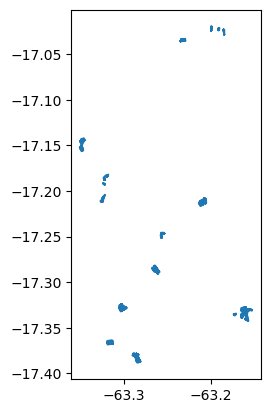

In [197]:
gdf_lines.plot()

In [198]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

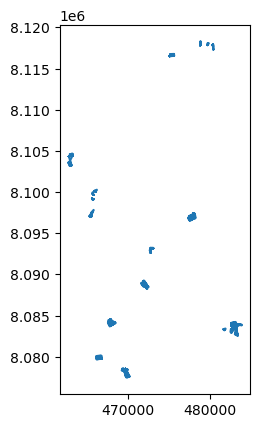

In [199]:
gdf_lines_utm.plot()

In [200]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [201]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2026-01-25 17-11-34.tlog,"LINESTRING (475081.371 8116511.648, 475082.275...",2000,DA04,0
1,2026-01-25 18-13-42.tlog,"LINESTRING (480308.668 8117885.350, 480308.679...",1089,DA04,0
2,2026-01-25 18-29-30.tlog,"LINESTRING (479651.922 8117857.637, 479651.730...",904,DA04,0
3,2026-01-25 18-41-42.tlog,"LINESTRING (478785.046 8117834.116, 478785.068...",907,DA04,0
4,2026-01-25 19-31-44.tlog,"LINESTRING (477451.172 8097084.372, 477451.183...",375,DA04,0
5,2026-01-25 19-36-20.tlog,"LINESTRING (477451.779 8097083.831, 477451.768...",305,DA04,0
6,2026-01-25 19-57-42.tlog,"LINESTRING (477450.929 8097083.244, 477450.929...",3552,DA04,0
7,2026-01-25 20-21-20.tlog,"LINESTRING (477954.572 8097404.013, 477954.668...",2022,DA04,0
8,2026-01-25 21-25-27.tlog,"LINESTRING (473065.412 8093164.322, 473065.444...",1984,DA04,0
9,2026-01-25 22-19-20.tlog,"LINESTRING (471987.817 8088648.130, 471987.807...",4683,DA04,0


In [202]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)